In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import seaborn as sns

%matplotlib inline

### Генерируем сбалансированную выборку

In [3]:
#train = pd.read_csv('/notebooks/data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long/data_train_balanced.csv')
train = pd.read_csv('/notebooks/data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long/data_train.csv')
train_types = np.abs(train['MCParticleType'])
part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}

selected_indexes = []

np.random.seed = 42

for part_code in part_codes.values():
    
    indxs = np.random.choice(train.index[train_types == part_code], 
                                size=5610, 
                                replace=False)
    
    selected_indexes += list(indxs)
    
train.loc[selected_indexes].to_csv('data/train_balanced_5k.csv', index=0)

In [40]:
train = pd.read_csv('data/train_balanced_5k.csv')

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]

train_types = np.abs(train['MCParticleType'])
train_types_encoding = {part_codes[code]:index for index, code in enumerate(particles)}
labels = train_types.apply(lambda x: train_types_encoding[x])

mc_features = ['Unnamed: 0', 'HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

train.drop(mc_features + constant_features, axis=1, inplace=1)
train.drop('Unnamed: 0.1', axis=1, inplace=1)
#eval.drop(mc_features + constant_features, axis=1, inplace=1)
print train.shape
#print eval.shape

(33660, 77)


In [28]:
eval = pd.read_csv('/notebooks/data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long/data_eval.csv')

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}

eval_types = np.abs(eval['MCParticleType'])
mask = eval_types.isin(part_codes.values())
eval = eval.loc[mask]
eval_types = eval_types[mask]
eval_labels = eval_types.apply(lambda x: train_types_encoding[x])

mc_features = ['Unnamed: 0', 'HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

eval.drop(mc_features + constant_features, axis=1, inplace=1)
print eval.shape

(999566, 77)


In [25]:
params = {}
params['objective'] = 'multi:softprob'
params['eta'] = 0.1
params['max_depth'] = 5
params['num_class'] = 6
params['numrounds'] = 180
params['colsample_bytree'] = 0.65
params['eval_metric'] = 'mlogloss'
params['nthread'] = 4
params['seed'] = 0

xgtrain = xgb.DMatrix(train, labels)
xgtest = xgb.DMatrix(eval)

In [26]:
%%time
model = xgb.train(params, xgtrain, num_boost_round=params['numrounds'])

CPU times: user 6min 19s, sys: 296 ms, total: 6min 19s
Wall time: 1min 35s


In [30]:
%%time
preds_xgboost = model.predict(xgtest)

CPU times: user 2min 48s, sys: 48 ms, total: 2min 48s
Wall time: 42.8 s


In [9]:
from utils import get_roc_curves, get_roc_auc_matrix

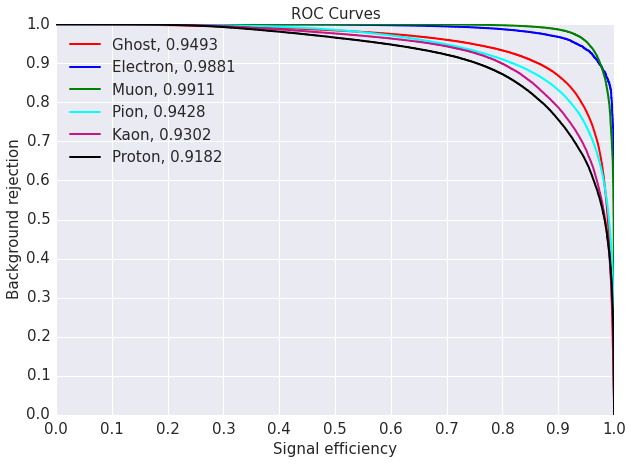

In [31]:
get_roc_curves(eval_labels, preds_xgboost, particles)

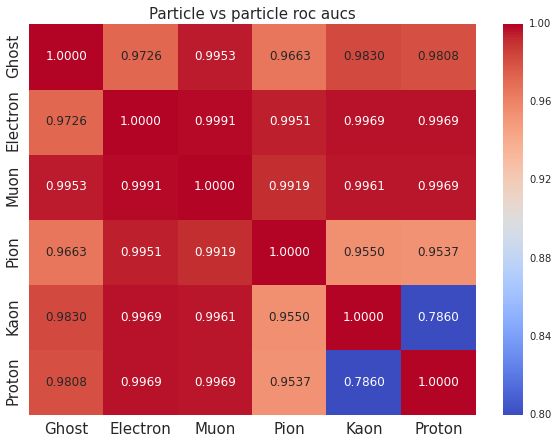

In [32]:
roc_auc_pairwise_my = get_roc_auc_matrix(eval_labels, preds_xgboost, particles)

In [33]:
from itertools import combinations

sum = 0.0

for ind1, ind2 in combinations(range(6), 2):
    sum += roc_auc_pairwise_my.iloc[ind1, ind2]
print 'Avg. pairwise ROC AUC: {0:0.4f}'.format(sum / 15)

Avg. pairwise ROC AUC: 0.9710


In [41]:
%%time
import utils

flatness = utils.get_flatness_table(eval, eval_labels, preds_xgboost, particles)

CPU times: user 17min 43s, sys: 256 ms, total: 17min 43s
Wall time: 17min 43s


In [42]:
flatness[['TrackP', 'TrackPt']].values.mean()

0.026080029186359779

In [43]:
from sklearn.metrics import log_loss

print log_loss(eval_labels, preds_xgboost)

0.679061724215


In [23]:
import cPickle as pickle

with open('xgboost_balanced5k.p', 'wb') as pkl:
    pickle.dump(model, pkl, pickle.HIGHEST_PROTOCOL)